# Load ds005514 and start training

In [1]:
from eegdash import EEGDash
from eegdash.data_utils import RawEEGDash

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.find({'dataset': 'ds005514', 'task': 'RestingState'})
records = records[0:10]

print("number of records: ", len(records))
print("first record: ", records[0]) # current call




number of records:  10
first record:  {'_id': ObjectId('6789a3c766ea5ef303140d0c'), 'schema_ref': 'eeg_signal', 'data_name': 'ds005514_sub-NDARRW481GFE_task-RestingState_eeg.set', 'dataset': 'ds005514', 'bidspath': 'ds005514/sub-NDARRW481GFE/eeg/sub-NDARRW481GFE_task-RestingState_eeg.set', 'subject': 'NDARRW481GFE', 'task': 'RestingState', 'session': '', 'run': '', 'sampling_frequency': 500, 'modality': 'EEG', 'has_file': True, 'version_timestamp': 0, 'time_of_save': 1739409119098056, 'time_of_removal': None, 'channel_names': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 

In [2]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {gender: i for i, gender in enumerate(['M','F'])}

allEEGDash = []
records[0]
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(RawEEGDash(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False), target_name='gender')
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'subject': record['subject']})
    allEEGDash.append(eegdash)


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\braindecode\datasets\base.py:131: UserWarning: 'gender' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [3]:
eegdash_braindecode = BaseConcatDataset(allEEGDash)

In [4]:
import numpy as np

res = eegdash_braindecode.description
res

,age,gender,subject
0,5.7012,M,NDARRW481GFE
1,13.5951,M,NDARTE553VC1
2,12.0696,F,NDARFJ488VPT
3,10.7882,F,NDARHT403JJJ
4,12.5762,M,NDARYW170CAA
5,10.0025,F,NDARYE017HZA
6,6.1071,M,NDARXX426ELJ
7,7.2295,M,NDARUZ818ADU
8,6.1426,M,NDARZZ741VJE
9,9.9038,M,NDARAW216PM7


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[ 2402.36499023,  2358.11035156,  2292.43237305, ...,
        -3395.13867188, -3489.63623047, -3587.44360352]]), array([ 10.   ,  10.002,  10.004, ..., 445.466, 445.468, 445.47 ]))
-3617.61279296875 4021.9267578125


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


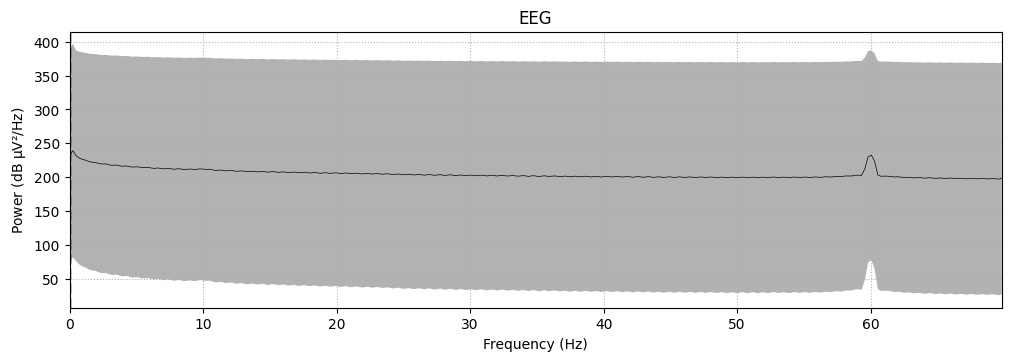

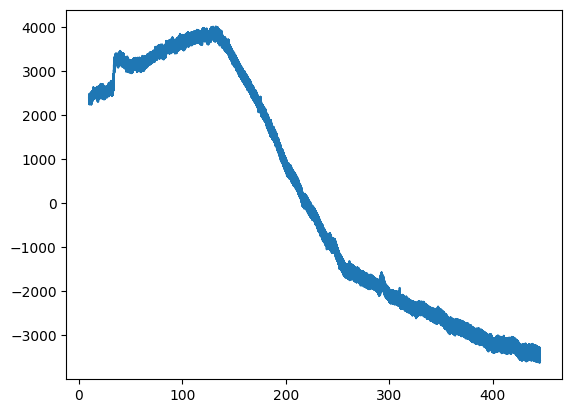

In [5]:
import matplotlib.pyplot as plt

raw = eegdash_braindecode.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

In [19]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

preprocessors = [   
    Preprocessor("filter", l_freq=1, h_freq=55),
    Preprocessor("resample", sfreq=125)
]

preprocess(eegdash_braindecode, preprocessors, n_jobs=-1)

windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=614,
        window_stride_samples=1000, drop_last_window=True,
        preload=False)

In [6]:
# if you run this cell as it loads all the data from disk

import os
from braindecode.datautil import load_concat_dataset

# probe user to continue by entering y
response = input("Press 'load' to continue: ")
print(response)
if response.lower() == 'load':
    print("Loading data from disk")
    windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)
else:
    # laod all the data
    for iWin in range(len(windows_ds)):
        res = windows_ds[iWin][0].shape
    os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
    windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)


load
Loading data from disk
Opening raw data file data\hbn_preprocessed_restingstate\0\0-raw.fif...
Isotrak not found
    Range : 0 ... 43645 =      0.000 ...   349.160 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingstate\1\1-raw.fif...
Isotrak not found
    Range : 0 ... 55683 =      0.000 ...   445.464 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingstate\2\2-raw.fif...
Isotrak not found
    Range : 0 ... 43895 =      0.000 ...   351.160 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingstate\3\3-raw.fif...
Isotrak not found
    Range : 0 ... 46777 =      0.000 ...   374.216 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingstate\4\4-raw.fif...
Isotrak not found
    Range : 0 ... 47190 =      0.000 ...   377.520 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingstate\5\5-raw.fif...
Isotrak not found
    Range : 0 ... 48808 =      0.000 ...   390.464 secs
Ready.
Opening raw data file data\hbn_preprocessed_restingsta

In [7]:
windows_ds[0]

(array([[-2.5606816e+07, -6.1840096e+07, -4.9406828e+07, ...,
         -5.0765137e+03,  5.0724175e+03, -5.0589844e+03],
        [ 1.0860875e-01,  1.7473912e+00,  1.9805173e+00, ...,
         -1.3204669e+02, -1.4131850e+02, -1.4610822e+02],
        [-7.7301512e+07, -1.8668206e+08, -1.4914867e+08, ...,
         -1.5881123e+04,  1.4716758e+04, -1.5887793e+04],
        ...,
        [ 4.1457018e-01,  2.0469706e+00,  1.9350067e+00, ...,
         -2.9914294e+02, -3.1945230e+02, -3.3064227e+02],
        [ 5.2106386e-01,  2.2075400e+00,  1.8170966e+00, ...,
         -4.5200211e+02, -4.8274506e+02, -4.9978577e+02],
        [ 2.6718548e-02,  2.4380152e+00,  1.5448010e+00, ...,
         -1.0433739e+03, -1.1144695e+03, -1.1539158e+03]], dtype=float32),
 'M',
 [0, 0, 614])

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
random_state = 42
subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [16]:
train_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_train])
val_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_valid])
test_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description['subject'] in subj_test])

loader_train = DataLoader(train_ds, batch_size=100, shuffle=True)


In [10]:
dataiter = iter(train_ds)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
label

'M'

In [13]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision.models as models

def create_model():
    subsample = 4
    tmp = models.vgg16()
    tmp.features = tmp.features[0:17]
    vgg16_rescaled = nn.Sequential()
    modules = []
    for layer in tmp.features.children():
        if isinstance(layer, nn.Conv2d):
            if layer.in_channels == 3:
                in_channels = 1
            else:
                in_channels = int(layer.in_channels/subsample)
            out_channels = int(layer.out_channels/subsample)
            modules.append(nn.Conv2d(in_channels, out_channels, layer.kernel_size, layer.stride, layer.padding))
        else:
            modules.append(layer)
    vgg16_rescaled.add_module('features',nn.Sequential(*modules))
    vgg16_rescaled.add_module('flatten', nn.Flatten())
    # vgg16_rescaled.flatten(vgg16_rescaled.features(torch.zeros((1, 3, 24, 24)))).shape
    modules = []
    for layer in tmp.classifier.children():
        if isinstance(layer, nn.Linear):
            if layer.in_features == 25088:
                in_features = 6144
            else:
                in_features = int(layer.in_features/subsample) 
            if layer.out_features == 1000:
                out_features = 2
            else:
                out_features = int(layer.out_features/subsample) 
            modules.append(nn.Linear(in_features, out_features))
        else:
            modules.append(layer)
    vgg16_rescaled.add_module('classifier', nn.Sequential(*modules))
    return vgg16_rescaled

lr = 0.001
model = create_model()
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)


In [18]:
import torch.nn.functional as F
def train(model, loader_train, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dtype = torch.float32
    print_every = 10
    gender_to_label = {'M': 0, 'F': 1}
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        count = 0
        for x, y_gender, z in iter(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_tmp = [gender_to_label[y_gender[i]] for i in range(len(y_gender))]
            y = torch.tensor(y_tmp, dtype=torch.long).to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if count % print_every == 0:
                print("Loss/train", loss.item(), e*len(loader_train)+count)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, count, loss.item()))
            count += 1
        
    return model

In [19]:
model = train(model, loader_train, optimizer, epochs=1)


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 100, 129, 614] to have 1 channels, but got 100 channels instead

In [49]:
gender_to_label = {'M': 0, 'F': 1}
gender_to_label['M', 'F']

KeyError: ('M', 'F')